# Challenge BASF

O objetivo desse notebook é propor uma visão analítica do relacionamento pós-venda dos clientes BASF buscando um entendimento sobre a avaliação positiva de clientes com relação a um produto ou atendimento e escrever comentários que não condiz com a sua avaliação.

Para isso vamos primeiramente passar por uma análise exploratória de dados usando ferramentas gráficas para criar gráficos autoexplicativos para entender melhor o que está por trás das avaliações.

Por fim, analisaremos as avaliações dos clientes e implementaremos a __**Análise Sentimental**__ para fazer uma classificação de texto usando as ferramentas de __**Natural Language Process**__.

#### Legendas
- Main Industry => Indústria
- Customer Network => É um cliente estratégico para BASF?**
- Local Invitation Date => Data que a pesquisa foi enviada
- Survey status => Status da pesquisa
- Local Response Date => Data de resposta
- Likelihood to Recommend => Probabilidade de Recomendar - Nota do NPS
- Ease of doing business => Facilidade de fazer negócios - Nota do Driver
- Issue Resolution => Resolução de Problemas - Nota do Driver
- Product Quality => Qualidade do Produto - Nota do Driver
- Delivery Reliability => Confiabilidade na Entrega - Nota do Driver
- Understanding your business needs => Entendendo as necessidades do seu negócio - Nota do Driver
- Alert type => Classificação da nota
- Current status of alert => Status da pesquisa dentro do Inner Loop
- Local Rapid Response Sent Date => Data de realização do feedback em 48h
- Due Date 20d => Data limite para realização do follow-up em 20 dias
- Local Alert Closed Date => Data de realização do follow-up
- What was the result of the follow-up conversation? => Teve algum problema relatado durante a conversa de follow-up?
- Outerloop Activity => Status dos problemas não resolvidos durante o follow-up em 20 dias
- Reason for Score => Razão pela nota de NPS Score atribuída
- Other Comment => Outros comentários deixados pelo cliente
- What did the customer tell you? What did you learn that should be shared? => Campo preencido pelo vendedor ao final da conversa de follow-up com o cliente
- Supporting your Business Comment => Último campo aberto da pesquisa: "Como a BASF pode contribuir para o sucesso da sua empresa e suas prioridades de negócios nos próximos meses?"

In [ ]:
!python -m spacy download en_core_web_sm

### Bibliotecas

In [1]:
# Apenas para evitar warnings 
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas padrão
import numpy as np
import pandas as pd
import re,string,unicodedata,math
from string import punctuation

# Bibliotecas de NLP
import nltk
# from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.stem.lancaster import LancasterStemmer
# from nltk.stem.porter import PorterStemmer
# from nltk.tokenize import word_tokenize
# from nltk.tokenize.treebank import TreebankWordDetokenizer
# from nltk import pos_tag
# from nltk.corpus import wordnet,stopwords
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import stanza
# import spacy

# SKLEARN
# from sklearn import metrics,svm,datasets,preprocessing
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer # BoW, TF-IDF, Hashing
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

# # TENSORFLOW
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense,LSTM,Dropout
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.layers import Bidirectional,Embedding,Flatten
# from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

# # Bibliotecas para exibição dos dados
# import seaborn as sns
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# from matplotlib import rcParams
# from plotly import subplots
# from plotly import tools
# import plotly.graph_objs as go
# from plotly.offline import iplot

# %matplotlib inline

# pd.options.plotting.backend = "plotly"

#### Lendo os dados

In [2]:
df = pd.read_csv('data/nps_basf_clean.csv', low_memory=False)

#### Copiando o dataset df e criando o dataset df_sample

In [3]:
df_sample = df[600:800]

In [4]:
print('O dataset contém {} linhas e {} colunas.'.format(df_sample.shape[0], df_sample.shape[1]))

O dataset contém 200 linhas e 28 colunas.


#### Removendo colunas que não serão utilizadas em nossa análise

In [5]:
df_sample = df_sample.drop([
    'Main Industry',
    'Ease of doing business',
    'Issue Resolution',
    'Product Quality',
    'Delivery Reliability',
    'Understanding your business needs',
    'Survey status',
    'Local Response Date', 
    'Current status of alert', 
    'Local Rapid Response Sent Date', 
    'Due Date 20d',
    'Local Alert Closed Date', 
    'Customer Network', 
    'Local Invitation Date',
    'What was the result of the follow-up conversation?', 
    'Outerloop Activity', 
    'Survey ID', 
    'Contact Country',
    'Job Title',
    'Contact Department',
    'Sold to', 
    'Lead Contact OD',
    'What did the customer tell you? What did you learn that should be shared?'
], axis=1)

In [6]:
df_sample.rename(columns = {'Likelihood to Recommend':'ratings'}, inplace = True)

#### Combinando os comentarios não irá contradizer a natureza dos sentimentos

In [7]:
df_sample['reviews'] = df_sample['Reason for Score'] + df_sample['Other Comment'] + df_sample['Supporting your Business Comment']
df_sample = df_sample.drop(['Reason for Score', 'Other Comment', 'Supporting your Business Comment'], axis=1)

#### Removendo dados nulos

In [8]:
df_sample['reviews'] = df_sample['reviews'].str.strip()
df_sample.replace('', np.nan, inplace=True)
df_sample.dropna(axis=0, inplace=True)

In [9]:
print('O dataset contém {} linhas e {} colunas após a remoção dos dados nulos.'.format(df_sample.shape[0], df_sample.shape[1]))

O dataset contém 36 linhas e 3 colunas após a remoção dos dados nulos.


### Text Normalization

Colocando o texto em uma estrutura que está em conformidade com os padrões da linguagem, usando as tecnicas:

- Spell correction
- Tokenization
- Stemming
- Lemmatization
- Sentence Segmentation

In [10]:
from nltk.corpus import wordnet,stopwords
stopwords = stopwords.words('english')

def standardize_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return ' '.join([word for word in text.split() if word not in (stopwords)])

In [11]:
df_sample['reviews'] = df_sample['reviews'].apply(lambda x: standardize_text(x))

In [12]:
df_sample.head(10)

,ratings,Alert type,reviews
607,10.0,Promoter,great quality products good service compliance...
608,8.0,Passive,already business basf good relationship good p...
615,9.0,Promoter,confidence partnership
616,10.0,Promoter,would recommend always well attended agility p...
637,10.0,Promoter,top team top consultant continue like
641,10.0,Promoter,great service high quality products great keep
646,7.0,Passive,product good price legal sac bad send catalogs...
651,8.0,Passive,excellent service provided rtv viviane rodrigu...
653,8.0,Passive,good products good service continuing serve wa...
655,10.0,Promoter,professionalism technical relational area aggr...


#### Spell correction

In [13]:
from spellchecker import SpellChecker
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

spell = SpellChecker(language="en")

text_formatted = []
line = []

for i in range(0,df_sample.shape[0]):
    word_tokens = word_tokenize(df_sample.iloc[i][2])
    line.append([spell.correction(word_tokens[x]) for x in range(len(word_tokens))])
    text_formatted.append(TreebankWordDetokenizer().detokenize(line[i]))

df_sample['reviews'] = text_formatted

In [14]:
df_sample.head(10)

,ratings,Alert type,reviews
607,10.0,Promoter,great quality products good service compliance...
608,8.0,Passive,already business base good relationship good p...
615,9.0,Promoter,confidence partnership
616,10.0,Promoter,would recommend always well attended agility p...
637,10.0,Promoter,top team top consultant continue like
641,10.0,Promoter,great service high quality products great keep
646,7.0,Passive,product good price legal sac bad send catalogs...
651,8.0,Passive,excellent service provided rev vivian rodrigue...
653,8.0,Passive,good products good service continuing serve wa...
655,10.0,Promoter,professionalism technical relational area aggr...


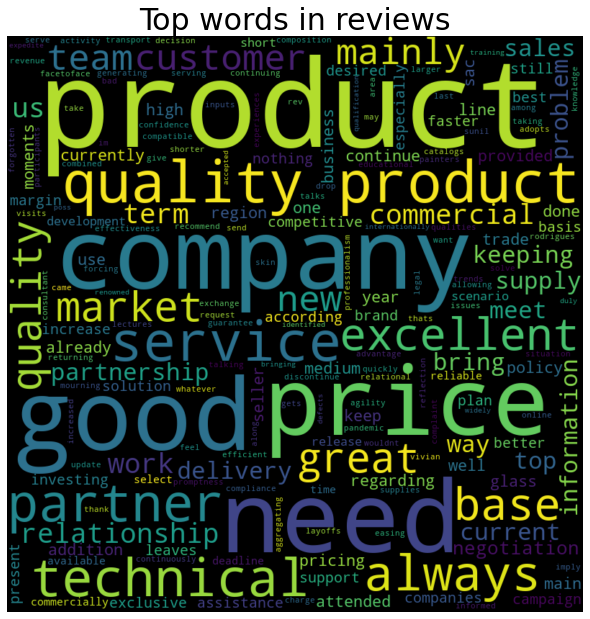

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='black',
                      min_font_size = 10
                     ).generate(" ".join(df_sample['reviews'].values))                      
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Top words in reviews",fontsize=30)
plt.show()

In [16]:
def classify_sentiment(sentiment):
    if sentiment == 'Passive':
        return 'Neutral'
    elif sentiment == 'Promoter':
        return 'Positive'
    else:
        return'Negativo'

In [17]:
df_sample['sentiment'] = df_sample['Alert type'].apply(classify_sentiment)

In [18]:
df_sample = df_sample.drop(['Alert type'], axis=1)

In [19]:
import math

def format_number(num):
    nr = round(num, 1)
    nc = re.sub(r'(?<=\d)[,\.](?=\d)','', str(nr))
    if nc != str(10):
        nc = str(nc)[::-1]
        nc = nc.replace('0', '')
    return np.fix(int(nc))

In [21]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag

measurements = []
cp, ps, ne, ng, rn = ([] for i in range(5))

sia = SentimentIntensityAnalyzer()

for i in range(0,df_sample.shape[0]):
    scores = sia.polarity_scores(df_sample.iloc[i][1])
    ps.append(scores['pos']) # score positivo
    ne.append(scores['neu']) # score neutro
    ng.append(scores['neg']) # score negativo
    cp.append(scores['compound']) # score agregado
    if scores['compound'] > 0:
        rn.append(format_number(scores['compound']))
    else:
        rn.append(0)

df_sample = df_sample.assign(
    score_positive=ps,
    score_neutral=ne,
    score_negative=ng,
    score_compound=cp,
    real_score_compound=rn
)

In [22]:
df_sample.head(10)

,ratings,reviews,sentiment,score_positive,score_neutral,score_negative,score_compound,real_score_compound
607,10.0,great quality products good service compliance...,Positive,0.327,0.673,0.000,0.8934,9.0
608,8.0,already business base good relationship good p...,Neutral,0.308,0.692,0.000,0.8316,8.0
615,9.0,confidence partnership,Positive,0.767,0.233,0.000,0.5106,5.0
616,10.0,would recommend always well attended agility p...,Positive,0.122,0.745,0.133,-0.1027,0.0
637,10.0,top team top consultant continue like,Positive,0.670,0.330,0.000,0.6249,6.0
641,10.0,great service high quality products great keep,Positive,0.621,0.379,0.000,0.8481,8.0
646,7.0,product good price legal sac bad send catalogs...,Neutral,0.302,0.530,0.168,0.5106,5.0
651,8.0,excellent service provided rev vivian rodrigue...,Neutral,0.310,0.579,0.112,0.5859,6.0
653,8.0,good products good service continuing serve wa...,Neutral,0.492,0.508,0.000,0.7003,7.0
655,10.0,professionalism technical relational area aggr...,Positive,0.000,1.000,0.000,0.0000,0.0


In [23]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

stemmer = PorterStemmer()
reviews_clean = df_sample['reviews'].apply(lambda v: ' '.join([stemmer.stem(word) for word in v.split(' ') if word not in stop_words]))

In [28]:
from wordcloud import WordCloud,STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score

train, test = train_test_split(
    reviews_clean,
    test_size=0.3,
    random_state=100
)

cv = CountVectorizer()
cv.fit(train)
X_train = cv.transform(train)
X_test = cv.transform(test)

y_train = df_sample.loc[train.index]['sentiment']
y_test = df_sample.loc[test.index]['sentiment']

# adaboost_model = RandomForestClassifier(n_estimators=300, random_state=100)
# adaboost_model.fit(X_train, y_train)
# pred_class = adaboost_model.predict(X_test)
# accuracy_score(y_test, pred_class)

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

pred = rf_model.predict(X_test)
accuracy_score(y_test, pred)


['Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive' 'Positive']


0.6363636363636364

#### Para dummy variable encoding para sentiment


In [ ]:
df_sample2 = pd.get_dummies(df_sample, columns=['sentiment'])

In [ ]:
df_sample2.head()

In [ ]:
#for evaluation of error term and 
def Evaluationmatrix(y_true, y_predict):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_true,y_predict)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_true,y_predict)))
    print ('Mean squared Log Error: '+ str(metrics.mean_squared_log_error(y_true,y_predict)))

In [ ]:
#to add into results_index for evaluation of error term 
def Evaluationmatrix_dict(y_true, y_predict, name = 'Linear - Integer'):
    dict_matrix = {}
    dict_matrix['Series Name'] = name
    dict_matrix['Mean Squared Error'] = metrics.mean_squared_error(y_true,y_predict)
    dict_matrix['Mean Absolute Error'] = metrics.mean_absolute_error(y_true,y_predict)
    dict_matrix['Mean Squared Log Error'] = metrics.mean_squared_log_error(y_true,y_predict)
    return dict_matrix

In [ ]:
#excluding Genre label
from sklearn.linear_model import LinearRegression 

#Integer encoding
X = df_sample.drop(labels = ['sentiment','ratings','reviews', 'sentiment_c'],axis = 1)
y = df_sample.ratings
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
model = LinearRegression()
model.fit(X_train,y_train)
Results = model.predict(X_test)

#Creation of results dataframe and addition of first entry
resultsdf = pd.DataFrame()
resultsdf = resultsdf.from_dict(Evaluationmatrix_dict(y_test,Results),orient = 'index')
resultsdf = resultsdf.transpose()

#dummy encoding

X_d = df_sample2.drop(labels = ['ratings','reviews', 'sentiment_Positive', 'sentiment_Negative', 'sentiment_Neutral'],axis = 1)
y_d = df_sample2.ratings
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)
model_d = LinearRegression()
model_d.fit(X_train_d,y_train_d)
Results_d = model_d.predict(X_test_d)

#adding results into results dataframe
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test_d,Results_d, name = 'Linear - Dummy'),ignore_index = True)